In [3]:
import operator
from functools import reduce
from itertools import product, starmap
from typing import Dict, Iterable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import sympy as sy

from utils.helpers import load_config


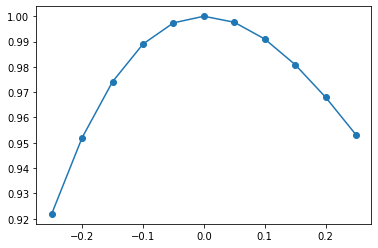

In [4]:
observations = np.linspace(-0.25, 0.25, 11)
references = observations**3 - observations**2 + 1
val = 0.985
plt.plot(observations, references)
plt.scatter(observations, references)

In [37]:
class LagrangeInterpolation:

    def __init__(self) -> None:
        pass

    def fit(self, X: Iterable, Y: Iterable):
        assert len(X) == len(Y)

        x_var = sy.Symbol('x')

        res = 0
        for idx, (obs, ref) in enumerate(zip(X, Y)):
            _rest = list(X[:idx]) + list(X[idx + 1:])

            __denom_coef = list(product([obs], _rest))
            __denom = list(
                starmap(lambda *s: sy.Rational(s[0] - s[1]), __denom_coef))
            __denom = reduce(operator.mul, __denom)

            __nom_coef = list(product([x_var], _rest))
            __nom = list(starmap(lambda *s: s[0] - s[1], __nom_coef))
            __nom = reduce(operator.mul, __nom)
            coef = ref / __denom
            res += __nom * coef
        self.res = res
        return res

    def eval(self, val):
        return self.res.subs({'x': val})

In [38]:
class NewtonInterpolation:

    def __init__(self):
        pass

    def __get_divided_differential__(self, X: Iterable, Y: Iterable):
        num_obs = len(X)
        res = np.zeros(shape=(num_obs, num_obs))

        res[:, 0] = Y
        for id_y in range(1, num_obs):
            for id_x in range(0, num_obs - id_y):
                differential = res[id_x + 1][id_y - 1] - res[id_x][id_y - 1]
                divided = X[id_x + id_y] - X[id_x]
                res[id_x][id_y] = differential / divided
        return res

    def fit(self, X: Iterable, Y: Iterable, method: str = 'forward'):
        assert len(X) == len(Y)

        x_var = sy.Symbol('x')

        divided_differential = self.__get_divided_differential__(X=X, Y=Y)

        res = 0
        term_list = []
        term = 1

        if method == 'forward':
            r = divided_differential[0]
        elif method == 'backward':
            r = np.fliplr(divided_differential).diagonal()

        for _, (obs, coef) in enumerate(zip(X, r)):
            res += coef * term
            term_list.append(coef * term)
            term *= (x_var - obs)
        self.res = res
        self.term_list = term_list
        return res

    def add_points(self, X: Iterable, Y: Iterable):
        pass

    def eval(self, val):
        return self.res.subs({'x': val})


In [39]:
class InverseInterpolation:

    def __init__(self, config: Dict) -> None:
        self.method = config['method']
        self.config = config[self.method]
        if config.get('method', False) == 'inverse_function':
            if config['inverse_function']['type'] == 'lagrange':
                self.interpolator = LagrangeInterpolation()
            elif config['inverse_function']['type'] == 'newton':
                self.interpolator = NewtonInterpolation()
        elif config.get('method', False) == 'iterative':
            self.interpolator = LagrangeInterpolation()

    def __get_monotonic_sequences__(self, Y: Iterable):
        """Xác định các chuỗi đơn điệu

        Args:
            Y (Iterable): Y

        Returns:
            [List[Tuple]]: Các khoảng đơn điệu, gồm điểm đầu và điểm cuối
        """
        indices = [0]
        diff = np.diff(Y)
        for idx in range(1, len(diff)):
            if diff[idx - 1] * diff[idx] < 0:
                indices.append(idx)
        indices.append(len(diff))
        return list(zip(indices, indices[1:]))

    def __get_isolation_interval__(self, Y: Iterable, target: float):
        """Tìm khoảng phân ly nghiệm

        Args:
            Y (Iterable): Y
            target (float): Giá trị cần tính

        Returns:
            [List[Tuple]]: Tập các khoảng phân ly nghiệm
        """
        indices = []
        diff = list(map(lambda ref: target - ref, Y))
        for index in range(1, len(Y)):
            if diff[index - 1] * diff[index] < 0:
                indices.append((index - 1, index))
        return indices

    def __get_divided_differential__(self, X: Iterable, Y: Iterable):
        """Bảng tỉ hiệu
        """
        num_obs = len(X)
        res = np.zeros(shape=(num_obs, num_obs))

        res[:, 0] = Y
        for id_y in range(1, num_obs):
            for id_x in range(0, num_obs - id_y):
                differential = res[id_x + 1][id_y - 1] - res[id_x][id_y - 1]
                divided = X[id_x + id_y] - X[id_x]
                res[id_x][id_y] = differential / divided
        return res

    def __get_containing_monotonic_seq__(self, monotonic_seq: Iterable,
                                         isolation_interval: Iterable):
        """Xác định khoảng đơn điệu chứa khoảng phân ly nghiệm

        Args:
            monotonic_seq (Iterable): Các khoảng đơn điệu
            isolation_interval (Iterable): Các khoảng phân ly nghiệm

        Returns:
            [Dict]: {Khoảng phân ly: Khoảng chứa}
        """
        res = {}
        for interval in isolation_interval:
            out = list(
                filter(
                    lambda s: (interval[0] - s[0]) * (interval[1] - s[1]) <= 0,
                    monotonic_seq))[0]
            res[interval] = out
        return res

    def __forward_or_backward__(self, Y: Iterable, isolation_interval: Tuple):
        """Newton tiến or lùi?

        Args:
            isolation_interval (Tuple): Các khoảng phân ly nghiệm

        Returns:
            [str]: tiến/lùi
        """
        if isolation_interval[1] + 1 < len(Y) - isolation_interval[0] + 1:
            return 'forward'
        return 'backward'

    def __fit_inverse_function__(self, X: Iterable, Y: Iterable, target: float):
        """Phương pháp dùng hàm ngược

        Args:
            X (Iterable): X
            Y (Iterable): Y
            target (float): Giá trị cần tính ngược

        Returns:
            (List): Tập nghiệm
        """
        monotonic_seq = self.__get_monotonic_sequences__(Y=Y)
        isolation_interval = self.__get_isolation_interval__(Y=Y, target=target)
        containing_seq = self.__get_containing_monotonic_seq__(
            monotonic_seq=monotonic_seq, isolation_interval=isolation_interval)

        res = []
        for seq in containing_seq.values():
            self.interpolator.fit(X=Y[seq[0]:seq[1] + 1],
                                  Y=X[seq[0]:seq[1] + 1])
            res.append(self.interpolator.eval(target))
        self.res = res
        return res

    def __fit_iterative__(self,
                          X: Iterable,
                          Y: Iterable,
                          target: float,
                          method: str = 'auto'):
        """Phương pháp lặp

        Args:
            X (Iterable): X
            Y (Iterable): Y
            target (float): Giá trị cần tính

        Returns:
            [List]: Tập nghiệm
        """
        h = np.diff(X)[0]

        def get_function(Y: Iterable,
                         ref: float,
                         val: float,
                         method: str = 'forward'):
            max_order = len(Y) - 1
            if method == 'forward':
                base_list = list(range(0, max_order))
            else:
                base_list = np.flip(list(range(-max_order + 1, 1)))
            pos = 0 if method == 'forward' else -1
            res = ref - Y[pos]
            denom = 1
            nume = (val - base_list[0]) * (val - base_list[1])
            for order in range(2, max_order):
                nume *= (val - base_list[order])
                denom *= order
                res -= np.diff(Y, order)[pos] * nume / denom
            return res / np.diff(Y, 1)[pos]

        isolation_interval = self.__get_isolation_interval__(Y=Y, target=target)
        """Note nhẹ
        """
        output = []
        for interval in isolation_interval:
            if method == 'auto':
                method = self.__forward_or_backward__(
                    Y, isolation_interval=interval)
            if method == 'forward':
                x = X[interval[0]:]
                y = Y[interval[0]:]
                u = (target - y[0]) / np.diff(Y, 1)[0]
                print('Forward')
                for ite in range(self.config['max_ite']):
                    u_old = u
                    u = get_function(y, val, u, method)
                    tol = np.abs(u - u_old)
                    if tol < float(self.config['tolerance']):
                        break
                root = x[0] + u*h
                output.append({
                    'root': root,
                    'iteration': ite + 1,
                    'tol': tol,
                    'isConvergence': bool(tol < 1e-4)
                })

            elif method == 'backward':
                x = X[:interval[1] + 1]
                y = Y[:interval[1] + 1]
                u = (target - y[-1]) / np.diff(Y, 1)[-1]
                print('Backward')
                for ite in range(self.config['max_ite']):
                    u_old = u
                    u = get_function(y, val, u, method)
                    tol = np.abs(u - u_old)
                    if tol < float(self.config['tolerance']):
                        break
                root = x[-1] + u*h
                output.append({
                    'root': root,
                    'iteration': ite + 1,
                    'tol': tol,
                    'isConvergence': bool(tol < 1e-4)
                })

        return output

    def fit(self, X: Iterable, Y: Iterable, target: float):
        assert len(X) == len(Y)

        monotonic_seq = self.__get_monotonic_sequences__(Y=Y)
        isolation_intervals = self.__get_isolation_interval__(Y=Y)

        containing_seq = self.__get_containing_monotonic_seq__(
            monotonic_seq=monotonic_seq, isolation_interval=isolation_intervals)

        res = 0
        # Statements here
        self.res = res
        return res

    def eval(self, val):
        return self.res.subs({'x': val})


In [40]:
config = {
    "method": "iterative",
    "inverse_function": {
        "type": "lagrange"
    },
    "iterative": {
        "type": "auto",
        "max_ite": 100,
        "tolerance": 0.000001
    }
}

In [41]:
client = InverseInterpolation(config)

In [42]:
x = np.array([1,2,3,4,5,6,7])/4
y = x**3  - x**2 - 1

In [43]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=x, y=y)
)

fig.write_image("poly_xy.png")

Forward
Forward


[{'root': -0.1109693279996872,
  'iteration': 9,
  'tol': 7.680881881633184e-07,
  'isConvergence': True},
 {'root': 0.12717593781166284,
  'iteration': 7,
  'tol': 5.6558014716046046e-08,
  'isConvergence': True}]

In [44]:
target = -0.5

In [45]:
print(client.__fit_inverse_function__(x, y, target))
print(client.__fit_iterative__(x, y, target, 'backward'))
print(client.__fit_iterative__(x, y, target))

[1.26732022120034]
Backward
[{'root': 1.1945714452637495, 'iteration': 100, 'tol': 2.3440037613008826, 'isConvergence': False}]
Backward
[{'root': 1.1945714452637495, 'iteration': 100, 'tol': 2.3440037613008826, 'isConvergence': False}]


In [46]:
y = 3*x + 2
y

array([2.75, 3.5 , 4.25, 5.  , 5.75, 6.5 , 7.25])

In [47]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=x, y=y)
)

fig.write_image("linear_xy.png")

In [48]:
target = 4.5

In [49]:
print(client.__fit_inverse_function__(x, y, target))
print(client.__fit_iterative__(x, y, target, 'forward'))
print(client.__fit_iterative__(x, y, target, 'backward'))

[0.833333333333333]
Forward
[{'root': -0.3383333333333334, 'iteration': 2, 'tol': 0.0, 'isConvergence': True}]
Backward
[{'root': -0.33833333333333315, 'iteration': 2, 'tol': 0.0, 'isConvergence': True}]
